In [1]:
import sys
import os

src_path = os.path.split(os.getcwd())[0]
sys.path.insert(0, src_path)

import numpy as np
import pandas as pd

import json
import logging
from pathlib import Path, PurePath
from collections import OrderedDict
from itertools import chain
import random
from PIL import Image


import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import clip.clip as clip
from training.datasets import CellPainting
from clip.clip import _transform
from clip.model import convert_weights, CLIPGeneral
from tqdm import tqdm
import itertools

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

from sklearn.manifold import TSNE

from huggingface_hub import hf_hub_download

In [21]:
seed=0
random.seed(seed)
np.random.seed(seed)

In [23]:
FILENAME = "cloome-retrieval-zero-shot.pt"
REPO_ID = "anasanchezf/cloome"
checkpoint_path = hf_hub_download(REPO_ID, FILENAME)

In [24]:
# CLOOB
model = "RN50"
image_resolution = 520
img_path = "<your-image-path>"
mol_path = "morgan_chiral_fps_1024.hdf5"
val = "subset-test-20-molecules.csv"

In [5]:
subset_val = pd.read_csv(val)

In [6]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad:
            p.grad.data = p.grad.data.float()

In [7]:
def load(model_path, device, model, image_resolution):
    checkpoint = torch.load(model_path)
    state_dict = checkpoint["state_dict"]

    model_config_file = os.path.join(src_path, f"training/model_configs/{model.replace('/', '-')}.json")

    print('Loading model from', model_config_file)
    assert os.path.exists(model_config_file)
    with open(model_config_file, 'r') as f:
        model_info = json.load(f)
    model = CLIPGeneral(**model_info)
    convert_weights(model)
    convert_models_to_fp32(model)

    if str(device) == "cpu":
        model.float()
    print(device)

    new_state_dict = {k[len('module.'):]: v for k,v in state_dict.items()}

    model.load_state_dict(new_state_dict)
    model.to(device)
    model.eval()

    return model, _transform(image_resolution, image_resolution,  is_train=False)

In [8]:
def get_features(dataset, model, device):
    all_image_features = []
    all_text_features = []
    all_ids = []

    print(f"get_features {device}")
    print(len(dataset))

    with torch.no_grad():
        for batch in tqdm(DataLoader(dataset, num_workers=20, batch_size=64, pin_memory=True)):
            if type(batch) is dict:
                imgs = batch
                text_features = None
                molecules_exist = False

            else:
                imgs, mols = batch
                mols = mols["input"]
                text_features = model.encode_text(mols.to(device))
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                all_text_features.append(text_features)
                molecules_exist = True
                
            images = imgs["input"]
            ids = imgs["ID"]

            img_features = model.encode_image(images.to(device))
            img_features = img_features / img_features.norm(dim=-1, keepdim=True)
            all_image_features.append(img_features)

            all_ids.append(ids)

            
        all_ids = list(chain.from_iterable(all_ids))
    
    if molecules_exist:
        return torch.cat(all_image_features), torch.cat(all_text_features), all_ids
    
    return torch.cat(all_image_features), all_ids

In [9]:
def main(df, model_path, model, img_path, mol_path=None, image_resolution=None):
    # Load the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(torch.cuda.device_count())

    model, preprocess = load(model_path, device, model, image_resolution)

    preprocess_train = _transform(image_resolution, image_resolution, is_train=True)
    preprocess_val = _transform(image_resolution, image_resolution, is_train=False, normalize="dataset", preprocess="downsize")

    # Load the dataset
    val = CellPainting(df,
                       img_path,
                       mol_path,
                       transforms = preprocess_val)

    # Calculate the image features
    print("getting_features")
    result = get_features(val, model, device)
    
    if len(result) > 2:
        val_img_features, val_text_features, val_ids = result
        return val_img_features, val_text_features, val_ids
    else:
        val_img_features, val_ids = result
        return val_img_features, val_ids

In [25]:
val_img_features, val_text_features, val_ids = main(val, checkpoint_path, model, img_path, mol_path, image_resolution)
val_img_features = val_img_features.cpu()
features_embedded = TSNE(n_components=2, learning_rate='auto',
                     init='random', metric="cosine", random_state=1, n_jobs=1).fit_transform(val_img_features)

2
Loading model from /publicwork/sanchez/cloob/src/training/model_configs/RN50.json
cuda
504
getting_features
get_features cuda
504


100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.23s/it]
/system/apps/userenv/sanchez/cloob/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
%matplotlib inline

In [12]:
import random

def generate_color():
    for i in range(3):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        rgb = np.array([r,g,b])/255
        return rgb
    
def gen_color_list(n):
    lst = []
    for i in range(n):
        rgb = generate_color()
        lst.append(rgb)
    return lst

print(len(set(subset_val["INCHIKEY"])))

20


In [13]:
def ordered_color_list(df, colors, group_dict):
    n_molecules = len(group_dict)

    scaled_colors = np.array(colors)/255

    #groups = df.groupby(group).groups

    ordered_colors = np.zeros((len(df), 3))


    for i, (group, indices) in enumerate(group_dict.items()): 
        ordered_colors[indices] = list(colors[i])
        

    #ordered_colors = ordered_colors/255
    return ordered_colors

In [14]:
def plot(features, colors, method):
    
    figure(figsize=(10, 8), dpi=100)

    plt.scatter(features[:, 0], features[:, 1], c=colors)
    
    method_list = [word for word in method.split()]
    method_string = "_".join(method_list)
    method, color_scheme = method_list
    
    plt.title(f"{method} embeddings (coloured by {color_scheme})")
    
    plt.tick_params(
    axis="both",       # changes apply to both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False)
    
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

        
    plt.show()

In [15]:
def morgan_from_smiles(smiles, radius=3, nbits=1024, chiral=True):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=nbits, useChirality=chiral)
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

In [16]:
def cellpainting_to_rgb(arr):
    arr0 = arr[:, :, 0].astype(np.float32)
    arr3 = arr[:, :, 3].astype(np.float32)
    arr4 = arr[:, :, 4].astype(np.float32)

    rgb_arr = np.dstack((arr0, arr3, arr4))
    
    return rgb_arr.astype(int)

In [17]:
def merge_imgs(mol_img_array, cell_img_array):
    new_im = np.full([mol_img_array.shape[0] + cell_img_array.shape[0], cell_img_array.shape[1], 3], 255, dtype=int)


    new_im[:cell_img_array.shape[0], :cell_img_array.shape[1]] = cell_img_array
    new_im[cell_img_array.shape[0]:, 198:-198] = mol_img_array

    return new_im

In [18]:
# first create a dict with an id (plate or molecule) and theis corresponding sample ids
# then make second dict with id (plate or molecule) and indexes in the array of embeddings
def find_order_by_group(ids_array, df, group):

    dict_ = {}
    val_ids = np.array(ids_array)

    for inchi in df.groupby(group).groups:
        sample_keys = list(df[df[group] == inchi]["SAMPLE_KEY"])
        dict_[inchi] = sample_keys

    dict_index = {}

    for inchi, ids in dict_.items():
        for i in ids:
            if i in val_ids:
                index = np.where(val_ids == i)[0][0]
                dict_index.setdefault(inchi, []).append(index)
                
    return dict_index

In [26]:
ord_mol_imgs = []
ord_imgs = []
ord_plates = []

for i in val_ids:
    smiles = subset_val[subset_val["SAMPLE_KEY"] == i]["SMILES"].tolist()[0]
    mols = Chem.MolFromSmiles(smiles)
    mol_img = Chem.Draw.MolToImage(mols)
    ord_mol_imgs.append(mol_img)
    
    filepath = f"{img_path}/{i}.npz"
    npz = np.load(filepath)
    if "sample" in npz:
        image = npz["sample"].astype(np.float32)
        ord_imgs.append(image)
        
        
    plate = subset_val[subset_val["SAMPLE_KEY"] == i]["PLATE_ID"].tolist()[0]
    ord_plates.append(plate)

mol_img_array = ord_mol_imgs

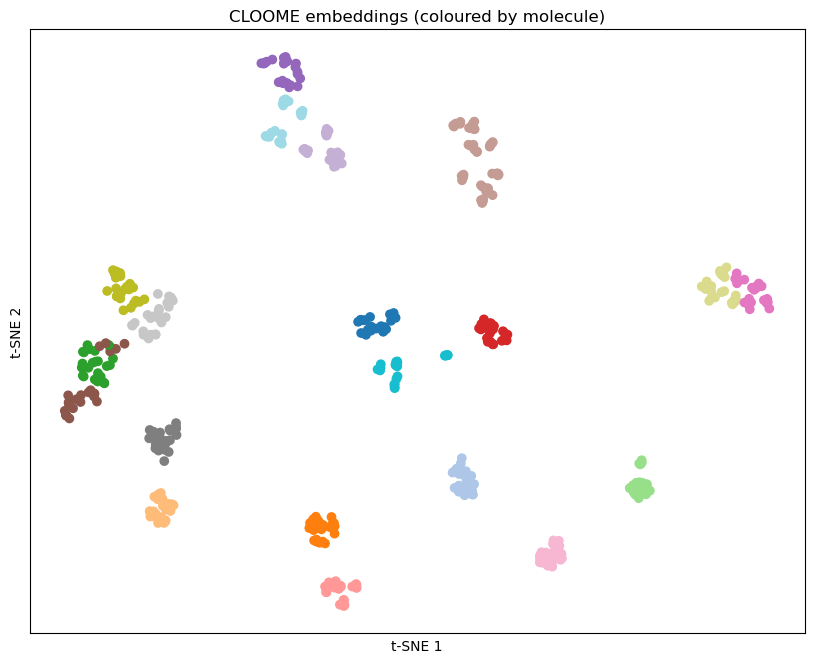

In [27]:
color_list = cm.tab20.colors
np_inchi_id = find_order_by_group(val_ids, subset_val, "INCHIKEY")
ordered_colors_mol = ordered_color_list(subset_val, color_list, np_inchi_id)
plot(features_embedded, ordered_colors_mol, "CLOOME molecule")

In [28]:
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib notebook
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [29]:
def interactive_plot(ord_imgs, ord_mol_imgs, ord_plates, val_ids, features_embedded, ordered_colors):
    cell_img_array = [cellpainting_to_rgb(arr) for arr in ord_imgs]


    mol_img_array = []

    for i, img in enumerate(ord_mol_imgs):
        new_im = img
        draw = ImageDraw.Draw(new_im)
        font = ImageFont.truetype("/publicwork/sanchez/data/Roboto-Black.ttf", 20)
        draw.text((100, 250), str(val_ids[i]), "black", font=font)
        arr = np.array(new_im)
        mol_img_array.append(arr)


    merged_arr = []

    for mol_arr, cell_arr in zip(mol_img_array, cell_img_array):
        new_im = merge_imgs(mol_arr, cell_arr)
        merged_arr.append(new_im)


    x, y = features_embedded[:, 0], features_embedded[:, 1]

    # create figure and plot scatter
    fig = plt.figure(figsize=(10, 8), dpi=80)
    ax = fig.add_subplot(111)
    line = ax.scatter(x, y, c=ordered_colors, s=10)
    ax.set_title("tSNE CLOOB")


    im = OffsetImage(merged_arr[0], zoom=0.5)


    xybox=(50., 50.)


    ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
            boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))


    # add it to the axes and make it invisible
    ax.add_artist(ab)
    ab.set_visible(False)


    def hover(event):
        # if the mouse is over the scatter points
        if line.contains(event)[0]:
            # find out the index within the array from the event
            ind, = line.contains(event)[1]["ind"]
            # get the figure size
            w,h = fig.get_size_inches()*fig.dpi
            ws = (event.x > w/2.)*-1 + (event.x <= w/2.)
            hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
            #if event occurs in the top or right quadrant of the figure,
            #change the annotation box position relative to mouse.
            ab.xybox = (xybox[0]*ws, xybox[1]*hs)
            # make annotation box visible
            ab.set_visible(True)
            # place it at the position of the hovered scatter point
            ab.xy =(x[ind], y[ind])
            # set the image corresponding to that point
            im.set_data(merged_arr[ind])
            
        else:
            #if the mouse is not over a scatter point
            ab.set_visible(False)
        fig.canvas.draw_idle()

    # add callback for mouse moves
    fig.canvas.mpl_connect('motion_notify_event', hover)
    plt.show()

<IPython.core.display.Javascript object>


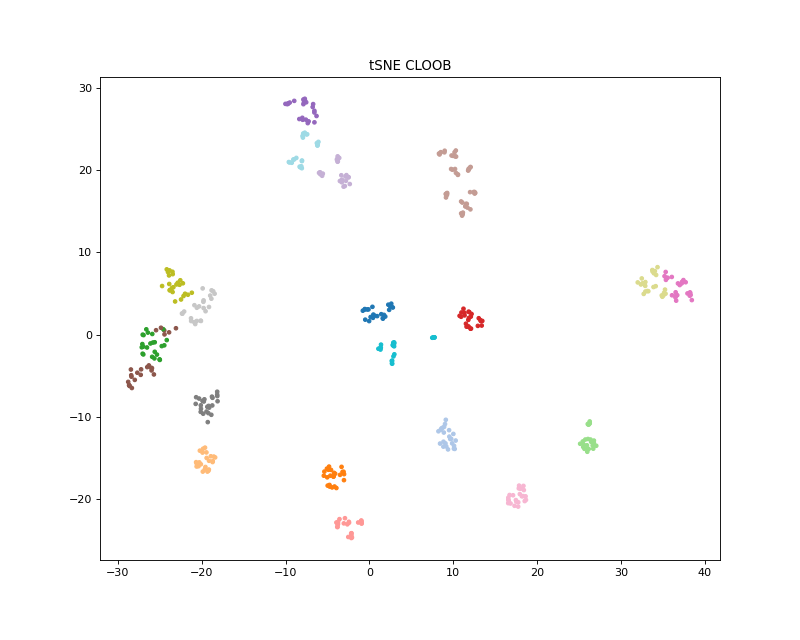

In [30]:
interactive_plot(ord_imgs, ord_mol_imgs, ord_plates, val_ids, features_embedded, ordered_colors_mol)

In [33]:
cellprofiler_file = "/publicdata/cellpainting/cellprofiler-features-image-level.npz"

cellprofiler_npz = np.load(cellprofiler_file)
rownames = cellprofiler_npz["rownames"]
colnames = cellprofiler_npz["colnames"]
cellprofiler_features = cellprofiler_npz["X"]

cellprofiler_df = pd.DataFrame(cellprofiler_features, index=rownames)
subset_cp = cellprofiler_df.loc[val_ids]
subset_ids = np.array(subset_cp.index)
subset_cp_arr = subset_cp.to_numpy()

In [34]:
dict_ = {}
val_ids = np.array(val_ids)

for inchi in subset_val.groupby("INCHIKEY").groups:
    sample_keys = list(subset_val[subset_val["INCHIKEY"] == inchi]["SAMPLE_KEY"])
    dict_[inchi] = sample_keys

np_inchi_id_cp = {}

for inchi, ids in dict_.items():
    for i in ids:
        if i in subset_ids:
            index = np.where(subset_ids == i)[0][0]
            np_inchi_id_cp.setdefault(inchi, []).append(index)

In [35]:
cellprofiler_features_embedded = TSNE(n_components=2, learning_rate='auto',
                     init='random', metric="l2", random_state=1).fit_transform(subset_cp_arr)


color_list = cm.tab20.colors
ordered_colors = ordered_color_list(subset_val, color_list, np_inchi_id_cp)

/system/apps/userenv/sanchez/cloob/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


<IPython.core.display.Javascript object>


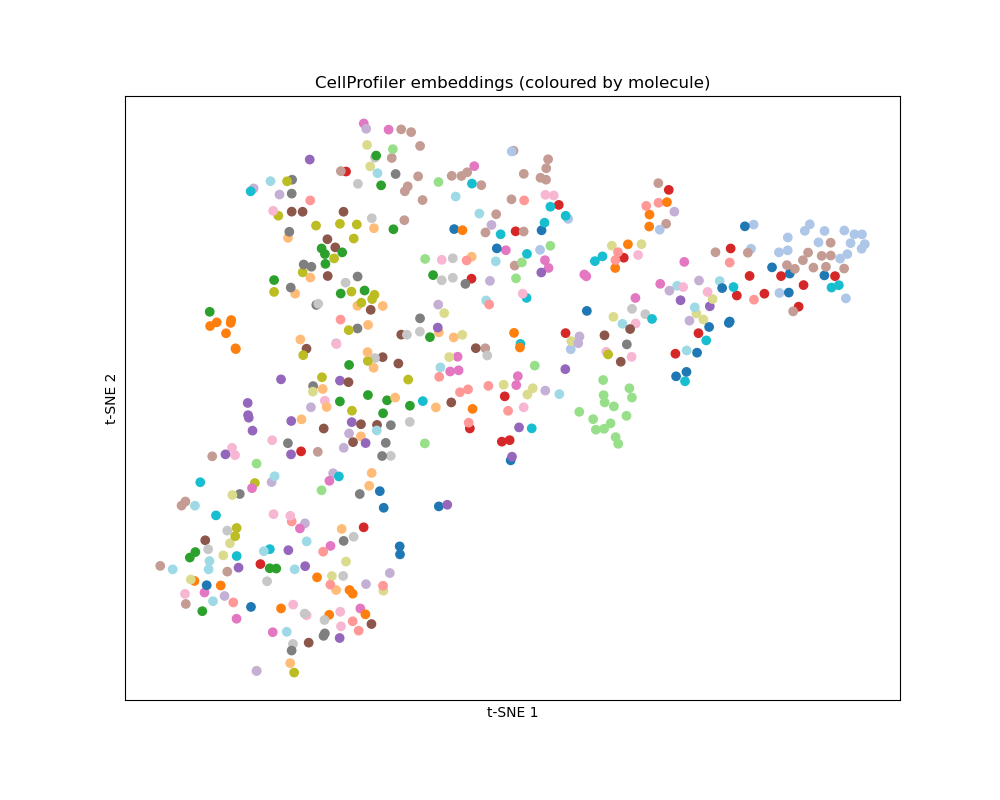

In [36]:
plot(cellprofiler_features_embedded, ordered_colors, "CellProfiler molecule")

In [37]:
m = cellprofiler_features.mean(axis=0)
std = cellprofiler_features.std(axis=0)

In [38]:
subset_cp_norm = (subset_cp_arr - m) / std

In [39]:
cellprofiler_features_norm_embedded = TSNE(n_components=2, learning_rate='auto',
                     init='random', metric="l2", random_state=1).fit_transform(subset_cp_norm)


color_list = cm.tab20.colors
ordered_colors = ordered_color_list(subset_val, color_list, np_inchi_id_cp)

/system/apps/userenv/sanchez/cloob/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


<IPython.core.display.Javascript object>


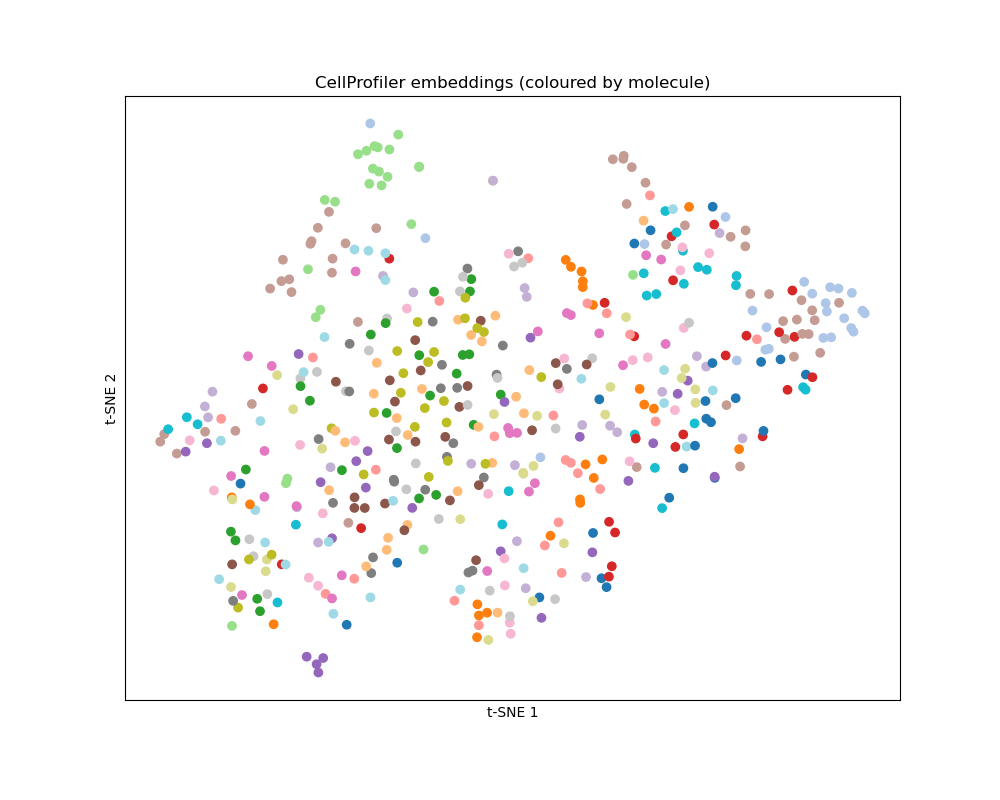

In [40]:
plot(cellprofiler_features_norm_embedded, ordered_colors, "CellProfiler molecule")

In [41]:
# plot 20 radomly selected plates 
val_plates = "/publicwork/sanchez/data/subset-test-20-plates.csv"
subset_val_plates = pd.read_csv(val_plates)
unique_mols = set(subset_val_plates["INCHIKEY"])

In [42]:
len(unique_mols)

575

In [44]:
val_img_plate_features, val_text_features, val_plate_ids = main(val_plates, checkpoint_path, model, img_path, mol_path, image_resolution)
val_img_plate_features = val_img_plate_features.cpu()

2
Loading model from /publicwork/sanchez/cloob/src/training/model_configs/RN50.json
cuda
3480
getting_features
get_features cuda
3480


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.15it/s]


In [50]:
tSNE_plates = TSNE(n_components=2, learning_rate='auto',
                     init='random', metric="cosine", random_state=1)
plate_features_embedded = tSNE_plates.fit_transform(val_img_plate_features)

/system/apps/userenv/sanchez/cloob/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


<IPython.core.display.Javascript object>


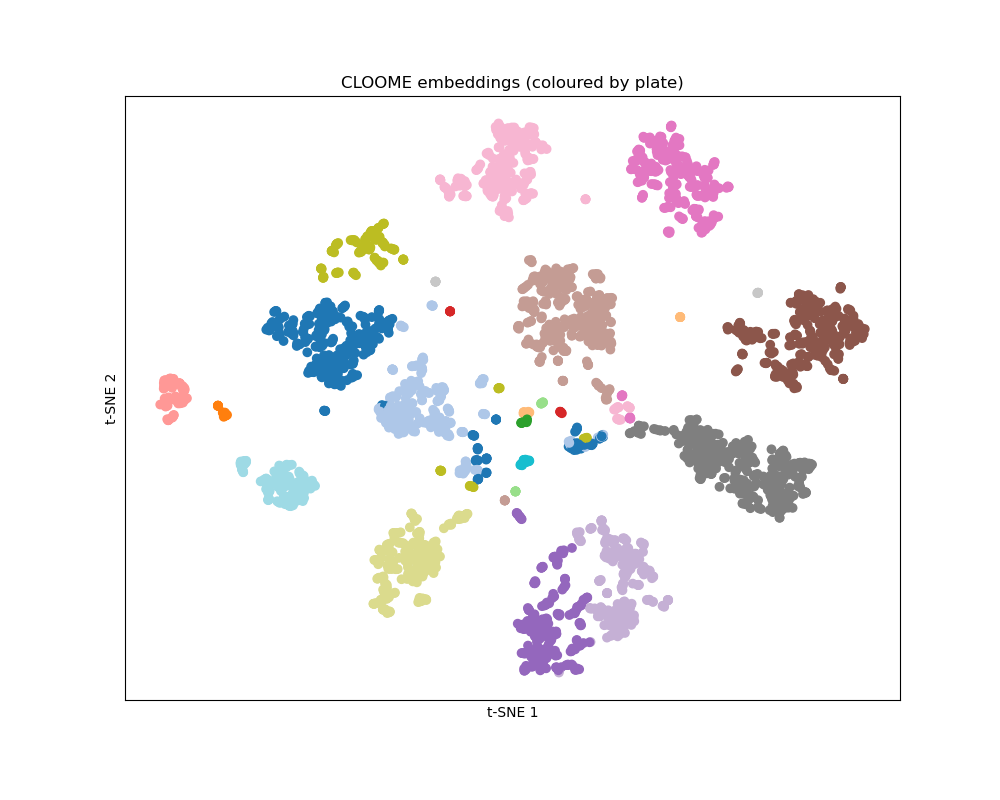

In [48]:
color_list = cm.tab20.colors
np_plate_id = find_order_by_group(val_plate_ids, subset_val_plates, "PLATE_ID")
ordered_colors_plate = ordered_color_list(subset_val_plates, color_list, np_plate_id)
plot(plate_features_embedded, ordered_colors_plate,"CLOOME plate")

<IPython.core.display.Javascript object>


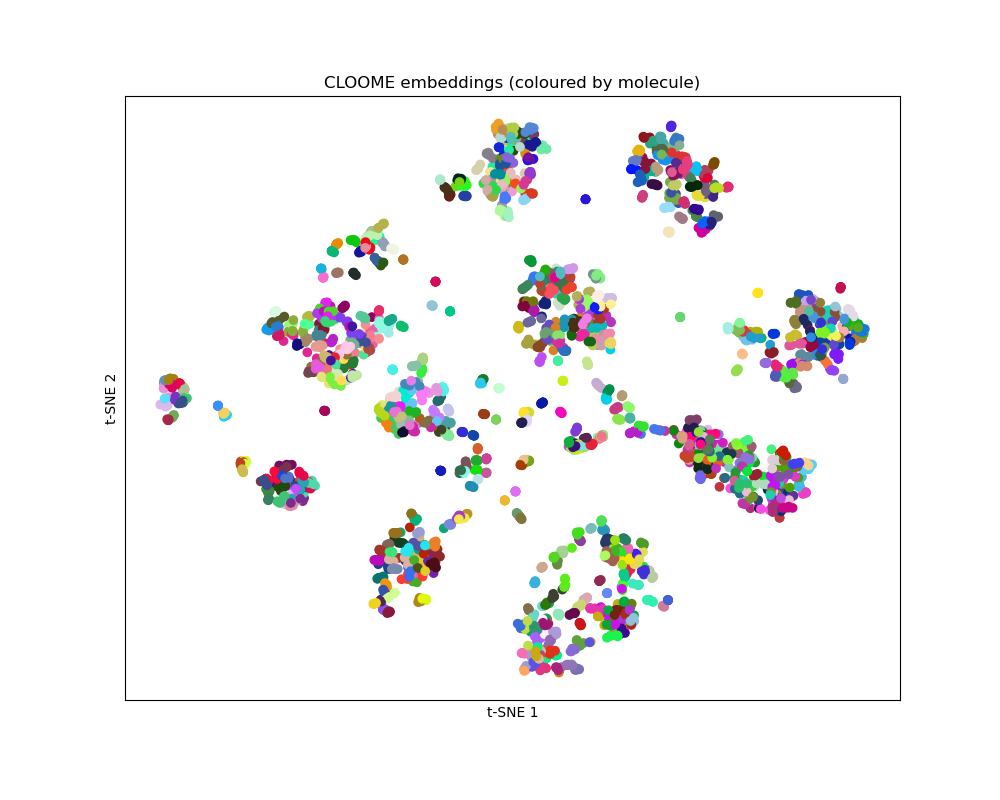

In [49]:
np_inchi_id = find_order_by_group(val_plate_ids, subset_val_plates, "INCHIKEY")
color_list = gen_color_list(len(np_inchi_id))
ordered_colors_plate = ordered_color_list(subset_val_plates, color_list, np_inchi_id)
plot(plate_features_embedded, ordered_colors_plate, "CLOOME molecule")